In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import scipy.stats as stats
import tensorflow_probability as tfp
import numpy as np
tfk = tf.keras
tfkl = tf.keras.layers
tfd = tfp.distributions
tfpl = tfp.layers
tf.enable_eager_execution()


In [14]:
dist  =tfd.Normal(loc=0.0,scale=1.0)
xdata = tf.linspace(-3.0,3.0,100)
ypdf = dist.prob(xdata)
ysamples = dist.sample(1000)


In [25]:
dist_list = [tfd.Normal(0.0,1.0),tfd.Normal(3.0,1.0),tfd.Normal(1.0,1.0)]

In [36]:
print([log_likelihood_cal(dist,ysamples) for dist in dist_list])

[<tf.Tensor: id=861, shape=(), dtype=float32, numpy=-1434.3107>, <tf.Tensor: id=872, shape=(), dtype=float32, numpy=-6099.7266>, <tf.Tensor: id=883, shape=(), dtype=float32, numpy=-1989.449>]


In [27]:
def log_likelihood_cal(dist,data):
    return tf.reduce_sum(dist.log_prob(data))

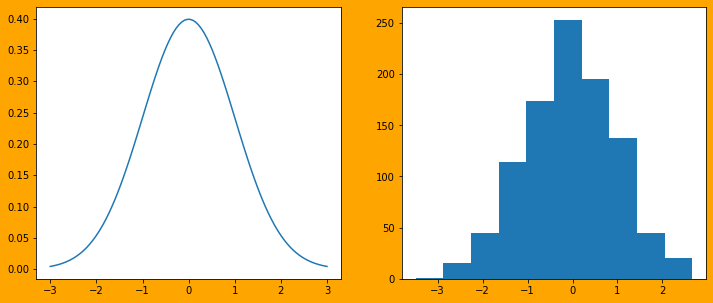

In [35]:
plt.figure(figsize=(12,5),facecolor='orange')
plt.subplot(121)
plt.plot(xdata,ypdf)
plt.subplot(122)
plt.hist(ysamples);

In [37]:
#@title Synthesize dataset.
w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
  np.random.seed(43)
  def s(x):
    g = (x - x_range[0]) / (x_range[1] - x_range[0])
    return 3 * (0.25 + g**2.)
  x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
  eps = np.random.randn(n) * s(x)
  y = (w0 * x * (1. + np.sin(x)) + b0) + eps
  x = x[..., np.newaxis]
  x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
  x_tst = x_tst[..., np.newaxis]
  return y, x, x_tst

y, x, x_tst = load_dataset()


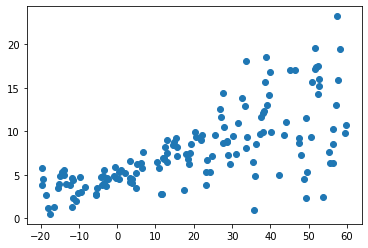

In [39]:
plt.scatter(x,y)

<h4> Regression model as $ P(y | x, w) $, the probability distribution of labels (y), given the inputs (x) and some parameters $(w)$.
We can fit this model to the data by maximizing the probability of the labels, or equivalently, minimizing the 
    negative log-likelihood loss:  $$ -log P(y | x)$$

In [41]:
log_neglikelihood = lambda y,rv:  -rv.log_prob(y)

In [42]:
model = tfk.Sequential([
    tfkl.Dense(1),
    tfpl.DistributionLambda(lambda t: tfd.Normal(loc=t,scale=1))
])

model.compile(optimizer=tf.keras.optimizers.Adam(.01),loss= log_neglikelihood )
model.fit(x,y,epochs=1000,verbose=False)

In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              multiple                  2         
_________________________________________________________________
distribution_lambda_1 (Distr multiple                  0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [ ]:
yhat = model(x_tst)


In [ ]:
mean = yhat.mean()
std   = yhat.stddev()
upper = mean + 2*std
lower = mean - 2*std

plt.scatter(x,y,label="observed")
plt.plot(x_tst,yhat.mean(),'r')
plt.plot(x_tst,upper,'b')
plt.plot(x_tst,lower,'b')
plt.legend()

In [ ]:
[w.numpy() for w in model.weights]

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1 + 1),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
])

model.compile(optimizer=tf.keras.optimizers.Adam(.01),loss= log_neglikelihood )
model.fit(x,y,epochs=1000,verbose=False)

In [ ]:
[w.numpy() for w in model.weights]
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

In [ ]:
mean = yhat.mean()
std   = yhat.stddev()
upper = mean + 2*std
lower = mean - 2*std

plt.scatter(x,y,label="observed")
plt.plot(x_tst,yhat.mean(),'r')
plt.plot(x_tst,upper,'b')
plt.plot(x_tst,lower,'b')
plt.legend()

In [ ]:
dataSample = yhat.sample(1)

In [ ]:
sns.distplot(np.squeeze(dataSample[0]))

In [ ]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

# Build model.
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Do inference.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=log_neglikelihood)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

In [ ]:
yhat_col = [model(x_tst) for _ in range(50)]

In [ ]:
plt.scatter(x,y)
main_m = 0
for i,yhat in enumerate(yhat_col):
    m = yhat.mean()
    plt.plot(x_tst,m,'r',linewidth=.5)
    main_m += m

plt.plot(x_tst,main_m/(len(yhat_col)),'r',linewidth = 3)
    

In [ ]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

# Build model.
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Do inference.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=log_neglikelihood)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

In [ ]:

yhat_col = [model(x_tst) for _ in range(50)]
plt.scatter(x,y)
main_m = 0
for i,yhat in enumerate(yhat_col):
    m = yhat.mean()
    s = yhat.stddev()
    plt.plot(x_tst,m,'r',linewidth=.5)
    plt.plot(x_tst,m-(2*s),'g',linewidth=.5)
    plt.plot(x_tst,m+(2*s),'g',linewidth=.5)
    main_m += m

#plt.plot(x_tst,main_m/(len(yhat_col)),'r',linewidth = 3)
    

## experimentation

In [53]:
model = tfk.Sequential([
    tfkl.Dense(1),
    tfpl.DistributionLambda(lambda t: tfd.Normal(loc=t,scale=1))
])

model.compile(optimizer=tf.keras.optimizers.Adam(.01),loss= log_neglikelihood)
model.fit(x,y,epochs=1000,verbose=False)